In [ ]:
!nvidia-smi

Sun Dec  4 20:24:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    19W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Setup

Access to Google Drive

In [ ]:
# import requirements
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Library

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import signal # for resample the signal (testing)
import random

from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Constants

In [ ]:
ID_EXERCISE_LABEL = -3
ID_CLUSTER_LABEL = -2
ID_SUBJECT_LABEL = -1

NORM_SAMPLE_LENGTH = 100
# --- Enable below for results of all 10 IMUs --- #
# CONSIDERED_IMU_POSITION = ['LeftShank', 'RightShank', 'LeftThigh', 'RightThigh', 'Pelvis', 'Chest', 'LeftFoot', 'RightFoot', 'LeftWrist', 'RightWrist']
CONSIDERED_IMU_POSITION = ['Chest', 'LeftFoot', 'LeftShank', 'LeftThigh', 'LeftWrist', 'Pelvis', 'RightFoot', 'RightShank', 'RightThigh', 'RightWrist']
# # --- Enable below for a subset of specific IMUs, remember to change depending on use --- #
# CONSIDERED_IMU_POSITION = ['RightWrist']
NOT_CONSIDERED_INFO = ['Time', 'Orientation', 'Magnetometer'] # not use these information
# NOT_CONSIDERED_INFO = ['Time', 'Orientation', 'Accelerometer', 'Magnetometer'] # additionally remove accelerometer info
# NOT_CONSIDERED_INFO = ['Time', 'Orientation', 'Gyroscope', 'Magnetometer'] # additionally remove gyroscope info
NUM_SENSOR_INFO = 2 # gyroscope and acceleration
# NUM_SENSOR_INFO = 1 # gyroscope or acceleration
NUM_AX_PER_SENSOR = 3 # x-, y-, and z-

NUM_SUBJECT = 20

In [ ]:
# Cluster from the clustering analysis
CLUSTER = [[0, 3, 6, 7, 24, 27, 28, 29, 30, 35],  # cluster 0
           [13, 14, 15, 16, 25],                  # cluster 1
           [12, 17, 20, 31, 32, 33, 34, 36],      # cluster 2
           [22],                                  # cluster 3
           [18, 19, 23, 26],                      # cluster 4
           [21],                                  # cluster 5
           [10, 11],                              # cluster 6
           [8, 9],                                # cluster 7
           [4, 5],                                # cluster 8
           [1, 2]]                                # cluster 9

In [ ]:
# --- Model hyper-parameters --- #
# Fixed parameters
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30
ADAM_WEIGHT_DECAY = 1e-2
LEARNING_RATE_REDUCTION_FACTOR = 0.5

# CONV_NUM_IN = 60 # temporarily hardcoded
num_imu = len(CONSIDERED_IMU_POSITION)
conv_num_in = num_imu*NUM_SENSOR_INFO*NUM_AX_PER_SENSOR

# Recorded tuning parameters

# # For all 10 IMUs
# # format: [batch_size, conv_num_out, kernel_size, stride_length, pool_size]
# print('10 IMUs')
# TUNED_HP = [[0, 0, 0, 0, 0],      # subject 1 <--- removed due to only 5 IMUs
#             [32, 256, 4, 1, 2],   # subject 2 left for testing
#             [64, 256, 4, 1, 2],   # subject 3 left for testing
#             [32, 256, 4, 1, 2],   # subject 4 left for testing
#             [32, 256, 4, 1, 2],   # subject 5 left for testing
#             [32, 128, 4, 1, 2],   # subject 6 left for testing
#             [32, 256, 4, 1, 2],   # subject 7 left for testing
#             [32, 256, 4, 1, 2],   # subject 8 left for testing
#             [32, 256, 4, 1, 2],   # subject 9 left for testing
#             [64, 128, 4, 1, 2],   # subject 10 left for testing
#             [32, 128, 4, 1, 2],   # subject 11 left for testing
#             [64, 256, 4, 1, 2],   # subject 12 left for testing
#             [32, 256, 4, 1, 2],   # subject 14 left for testing
#             [32, 128, 4, 1, 2],   # subject 15 left for testing
#             [32, 256, 4, 1, 2],   # subject 16 left for testing
#             [128, 256, 4, 1, 2],  # subject 17 left for testing
#             [64, 128, 4, 1, 2],   # subject 18 left for testing
#             [64, 256, 4, 1, 2],   # subject 19 left for testing
#             [64, 256, 4, 1, 2],   # subject 21 left for testing
#             [32, 128, 4, 1, 2]]   # subject 22 left for testing

# Right wrist
TUNED_HP = [[0, 0, 0, 0, 0],      # subject 1 <--- removed due to only 5 IMUs
            [128, 256, 4, 1, 2],   # subject 2 left for testing
            [128, 256, 4, 1, 2],   # subject 3 left for testing
            [32, 256, 4, 1, 2],   # subject 4 left for testing
            [32, 256, 4, 1, 2],   # subject 5 left for testing
            [128, 256, 4, 1, 2],   # subject 6 left for testing
            [128, 256, 4, 1, 2],   # subject 7 left for testing
            [128, 256, 4, 1, 2],   # subject 8 left for testing
            [32, 256, 4, 1, 2],   # subject 9 left for testing
            [128, 256, 4, 1, 2],   # subject 10 left for testing
            [128, 256, 4, 1, 2],   # subject 11 left for testing
            [64, 256, 4, 1, 2],   # subject 12 left for testing
            [128, 256, 4, 1, 2],   # subject 14 left for testing
            [16, 128, 4, 1, 2],   # subject 15 left for testing
            [32, 256, 4, 1, 2],   # subject 16 left for testing
            [16, 256, 4, 1, 2],  # subject 17 left for testing
            [32, 256, 4, 1, 2],   # subject 18 left for testing
            [32, 256, 4, 1, 2],   # subject 19 left for testing
            [128, 256, 4, 1, 2],   # subject 21 left for testing
            [128, 256, 4, 1, 2]]   # subject 22 left for testing

# # Chest
# TUNED_HP = [[0, 0, 0, 0, 0],      # subject 1 <--- removed due to only 5 IMUs
#             [64, 256, 4, 1, 2],   # subject 2 left for testing
#             [64, 256, 4, 1, 2],   # subject 3 left for testing
#             [128, 256, 4, 1, 2],   # subject 4 left for testing
#             [128, 256, 4, 1, 2],   # subject 5 left for testing
#             [128, 256, 4, 1, 2],   # subject 6 left for testing
#             [128, 256, 4, 1, 2],   # subject 7 left for testing
#             [64, 256, 4, 1, 2],   # subject 8 left for testing
#             [128, 256, 4, 1, 2],   # subject 9 left for testing
#             [128, 256, 4, 1, 2],   # subject 10 left for testing
#             [128, 256, 4, 1, 2],   # subject 11 left for testing
#             [128, 256, 4, 1, 2],   # subject 12 left for testing
#             [128, 256, 4, 1, 2],   # subject 14 left for testing
#             [128, 128, 4, 1, 2],   # subject 15 left for testing
#             [128, 256, 4, 1, 2],   # subject 16 left for testing
#             [64, 128, 4, 1, 2],  # subject 17 left for testing
#             [64, 256, 4, 1, 2],   # subject 18 left for testing
#             [128, 256, 4, 1, 2],   # subject 19 left for testing
#             [128, 256, 4, 1, 2],   # subject 21 left for testing
#             [128, 256, 4, 1, 2]]   # subject 22 left for testing

# # Pelvis
# TUNED_HP = [[0, 0, 0, 0, 0],      # subject 1 <--- removed due to only 5 IMUs
#             [16, 256, 4, 1, 2],   # subject 2 left for testing
#             [16, 256, 4, 1, 2],   # subject 3 left for testing
#             [16, 256, 4, 1, 2],   # subject 4 left for testing
#             [128, 256, 4, 1, 2],   # subject 5 left for testing
#             [16, 256, 4, 1, 2],   # subject 6 left for testing
#             [16, 256, 4, 1, 2],   # subject 7 left for testing
#             [64, 256, 4, 1, 2],   # subject 8 left for testing
#             [16, 256, 4, 1, 2],   # subject 9 left for testing
#             [128, 256, 4, 1, 2],   # subject 10 left for testing
#             [16, 256, 4, 1, 2],   # subject 11 left for testing
#             [16, 256, 4, 1, 2],   # subject 12 left for testing
#             [64, 256, 4, 1, 2],   # subject 14 left for testing
#             [16, 256, 4, 1, 2],   # subject 15 left for testing
#             [64, 256, 4, 1, 2],   # subject 16 left for testing
#             [64, 256, 4, 1, 2],  # subject 17 left for testing
#             [128, 256, 4, 1, 2],   # subject 18 left for testing
#             [16, 256, 4, 1, 2],   # subject 19 left for testing
#             [128, 256, 4, 1, 2],   # subject 21 left for testing
#             [16, 256, 4, 1, 2]]   # subject 22 left for testing

# # Right thigh
# TUNED_HP = [[0, 0, 0, 0, 0],      # subject 1 <--- removed due to only 5 IMUs
#             [64, 256, 4, 1, 2],   # subject 2 left for testing
#             [128, 256, 4, 1, 2],   # subject 3 left for testing
#             [128, 256, 4, 1, 2],   # subject 4 left for testing
#             [128, 256, 4, 1, 2],   # subject 5 left for testing
#             [64, 256, 4, 1, 2],   # subject 6 left for testing
#             [64, 256, 4, 1, 2],   # subject 7 left for testing
#             [128, 256, 4, 1, 2],   # subject 8 left for testing
#             [128, 256, 4, 1, 2],   # subject 9 left for testing
#             [128, 256, 4, 1, 2],   # subject 10 left for testing
#             [64, 256, 4, 1, 2],   # subject 11 left for testing
#             [128, 256, 4, 1, 2],   # subject 12 left for testing
#             [128, 256, 4, 1, 2],   # subject 14 left for testing
#             [128, 256, 4, 1, 2],   # subject 15 left for testing
#             [64, 256, 4, 1, 2],   # subject 16 left for testing
#             [64, 256, 4, 1, 2],  # subject 17 left for testing
#             [64, 256, 4, 1, 2],   # subject 18 left for testing
#             [64, 256, 4, 1, 2],   # subject 19 left for testing
#             [128, 256, 4, 1, 2],   # subject 21 left for testing
#             [64, 256, 4, 1, 2]]   # subject 22 left for testing

# # Left & right thigh
# TUNED_HP = [[0, 0, 0, 0, 0],      # subject 1 <--- removed due to only 5 IMUs
#             [128, 256, 4, 1, 2],   # subject 2 left for testing
#             [64, 256, 4, 1, 2],   # subject 3 left for testing
#             [64, 256, 4, 1, 2],   # subject 4 left for testing
#             [64, 256, 4, 1, 2],   # subject 5 left for testing
#             [64, 256, 4, 1, 2],   # subject 6 left for testing
#             [128, 256, 4, 1, 2],   # subject 7 left for testing
#             [64, 256, 4, 1, 2],   # subject 8 left for testing
#             [64, 256, 4, 1, 2],   # subject 9 left for testing
#             [64, 256, 4, 1, 2],   # subject 10 left for testing
#             [128, 256, 4, 1, 2],   # subject 11 left for testing
#             [64, 256, 4, 1, 2],   # subject 12 left for testing
#             [64, 256, 4, 1, 2],   # subject 14 left for testing
#             [64, 256, 4, 1, 2],   # subject 15 left for testing
#             [128, 256, 4, 1, 2],   # subject 16 left for testing
#             [128, 256, 4, 1, 2],  # subject 17 left for testing
#             [64, 256, 4, 1, 2],   # subject 18 left for testing
#             [64, 256, 4, 1, 2],   # subject 19 left for testing
#             [128, 256, 4, 1, 2],   # subject 21 left for testing
#             [128, 256, 4, 1, 2]]   # subject 22 left for testing

# # Chest & right thigh
# TUNED_HP = [[0, 0, 0, 0, 0],      # subject 1 <--- removed due to only 5 IMUs
#             [128, 256, 4, 1, 2],   # subject 2 left for testing
#             [64, 256, 4, 1, 2],   # subject 3 left for testing
#             [32, 256, 4, 1, 2],   # subject 4 left for testing
#             [64, 256, 4, 1, 2],   # subject 5 left for testing
#             [64, 256, 4, 1, 2],   # subject 6 left for testing
#             [64, 256, 4, 1, 2],   # subject 7 left for testing
#             [64, 256, 4, 1, 2],   # subject 8 left for testing
#             [128, 256, 4, 1, 2],   # subject 9 left for testing
#             [128, 256, 4, 1, 2],   # subject 10 left for testing
#             [128, 256, 4, 1, 2],   # subject 11 left for testing
#             [64, 256, 4, 1, 2],   # subject 12 left for testing
#             [64, 256, 4, 1, 2],   # subject 14 left for testing
#             [128, 256, 4, 1, 2],   # subject 15 left for testing
#             [128, 256, 4, 1, 2],   # subject 16 left for testing
#             [128, 256, 4, 1, 2],  # subject 17 left for testing
#             [32, 256, 4, 1, 2],   # subject 18 left for testing
#             [64, 256, 4, 1, 2],   # subject 19 left for testing
#             [128, 256, 4, 1, 2],   # subject 21 left for testing
#             [128, 256, 4, 1, 2]]   # subject 22 left for testing

# # Right thigh & shank
# TUNED_HP = [[0, 0, 0, 0, 0],      # subject 1 <--- removed due to only 5 IMUs
#             [128, 256, 4, 1, 2],   # subject 2 left for testing
#             [128, 256, 4, 1, 2],   # subject 3 left for testing
#             [64, 256, 4, 1, 2],   # subject 4 left for testing
#             [128, 256, 4, 1, 2],   # subject 5 left for testing
#             [128, 256, 4, 1, 2],   # subject 6 left for testing
#             [64, 256, 4, 1, 2],   # subject 7 left for testing
#             [128, 256, 4, 1, 2],   # subject 8 left for testing
#             [64, 256, 4, 1, 2],   # subject 9 left for testing
#             [64, 256, 4, 1, 2],   # subject 10 left for testing
#             [64, 256, 4, 1, 2],   # subject 11 left for testing
#             [64, 256, 4, 1, 2],   # subject 12 left for testing
#             [64, 256, 4, 1, 2],   # subject 14 left for testing
#             [64, 256, 4, 1, 2],   # subject 15 left for testing
#             [32, 256, 4, 1, 2],   # subject 16 left for testing
#             [128, 256, 4, 1, 2],  # subject 17 left for testing
#             [64, 256, 4, 1, 2],   # subject 18 left for testing
#             [128, 256, 4, 1, 2],   # subject 19 left for testing
#             [64, 256, 4, 1, 2],   # subject 21 left for testing
#             [128, 256, 4, 1, 2]]   # subject 22 left for testing

# # Right thigh & wrist
# TUNED_HP = [[0, 0, 0, 0, 0],      # subject 1 <--- removed due to only 5 IMUs
#             [32, 128, 4, 1, 2],   # subject 2 left for testing
#             [32, 256, 4, 1, 2],   # subject 3 left for testing
#             [64, 256, 4, 1, 2],   # subject 4 left for testing
#             [64, 256, 4, 1, 2],   # subject 5 left for testing
#             [32, 256, 4, 1, 2],   # subject 6 left for testing
#             [32, 256, 4, 1, 2],   # subject 7 left for testing
#             [64, 256, 4, 1, 2],   # subject 8 left for testing
#             [32, 128, 4, 1, 2],   # subject 9 left for testing
#             [32, 256, 4, 1, 2],   # subject 10 left for testing
#             [32, 256, 4, 1, 2],   # subject 11 left for testing
#             [32, 256, 4, 1, 2],   # subject 12 left for testing
#             [32, 256, 4, 1, 2],   # subject 14 left for testing
#             [32, 128, 4, 1, 2],   # subject 15 left for testing
#             [32, 256, 4, 1, 2],   # subject 16 left for testing
#             [32, 128, 4, 1, 2],   # subject 17 left for testing
#             [32, 256, 4, 1, 2],   # subject 18 left for testing
#             [32, 256, 4, 1, 2],   # subject 19 left for testing
#             [32, 128, 4, 1, 2],   # subject 21 left for testing
#             [32, 256, 4, 1, 2]]   # subject 22 left for testing

# Id for tuning parameters
ID_BATCH_SIZE = 0
ID_NUM_OUT = 1
ID_KERNEL_SIZE = 2
ID_STRIDE = 3
ID_POOL_SIZE = 4

#Utils

Pre-processing

In [ ]:
# all helper function here
# helper functions
def mkfolder(pth):
  if not os.path.exists(pth):
    os.mkdir(pth)

def read(pth):
  return pd.read_csv(pth)

# Load and re-format the data file
def load_df(pth):
  dtframe = read(pth)
  dtframe = dtframe.iloc[:, 3:] # remove the first 3 columns

  # Re-formatting the column's names
  # e.g., Pevist Accelerometer X, LeftFoot Gyroscope Z, etc.
  names = list(dtframe.columns)
  names = [name.split('.')[0] for name in names]
  names_2 = dtframe.iloc[0, :]
  names_3 = dtframe.iloc[1, :]

  for i in range(len(names)):
    names[i] = names[i]+' '+names_2[i]+' '+names_3[i]

  dtframe = dtframe.iloc[2:, :] # remove the first 2 rows
  dtframe.columns = names # update new column's names

  return dtframe

def slice_df(dtframe):
  cols = sorted(dtframe.columns)

  req_cols = [col for col in cols if col.split(' ')[0] in CONSIDERED_IMU_POSITION] # only keep data from considered sensors (may not be all 10), e.g., chest, pelvis, etc.
  req_cols = [col for col in req_cols if col.split(' ')[1] not in NOT_CONSIDERED_INFO] # not use information from orientation, magnetometer or time

  dtframe = dtframe.loc[:, req_cols]

  return dtframe

# One hot encoding
def one_hot_encoding(label, num_clasess):
  temp = np.zeros(num_clasess)
  temp[label] = 1

  return temp

# One hot decoding
def one_hot_decoding(num):
  if num.shape[0] > 0:
    temp = np.array([np.where(row == 1) for row in num])
  else:
    temp = np.argwhere(num == 1)

  return temp

# Normalize data to have the same sample length for training the network
def normLength(arr, maxlength):
  new_arr = np.zeros((maxlength, arr.shape[-1]))
  for i in range(arr.shape[-1]):
    a = arr[:, i]
    k = a.shape[0]
    y = np.interp(np.linspace(0, 1, maxlength), np.linspace(0, 1, k), a)
    new_arr[:, i] = y
  return new_arr

# Obtain cluster label from the previous clustering analysis
def get_cluster_label(ex_code):
  cluster_found = False
  cluster_id = 0

  while not cluster_found:
    if ex_code in CLUSTER[cluster_id]:
      cluster_found = True
    else:
      cluster_id += 1 # increase the id

  return cluster_id


Dataset handler

In [ ]:
class MyDataset(Dataset):
    def __init__(self, list_of_samples, to_size, num_classes):
      self.to_size = to_size

      list_of_samples = [normLength(sample, NORM_SAMPLE_LENGTH).T for sample in list_of_samples]

      self.X = [sample[:ID_EXERCISE_LABEL, :] for sample in list_of_samples] # <-- take only 60 columns of data
      
      if num_classes < 37:
        self.Y = [one_hot_encoding(int(sample[ID_CLUSTER_LABEL, :][0]), num_classes) for sample in list_of_samples]
      else:
        self.Y = [one_hot_encoding(int(sample[ID_EXERCISE_LABEL, :][0]), num_classes) for sample in list_of_samples]

    def __len__(self):
      return len(self.Y)

    def __getitem__(self, idx):
      x = torch.from_numpy(self.X[idx]).float()
      y = self.Y[idx]
      # y = int(self.Y[0])
      # y = np.array(y)
      if device == 'cuda':
        x = x.to(device)
        y = torch.from_numpy(y)
        y = y.to(device)
      return x, y

Model

In [ ]:
class CNN_Alter_Block(nn.Module):
    def __init__(self, num_in, num_out, kernel_size, stride, pool_size, num_classes):
        super(CNN_Alter_Block, self).__init__()
        self.conv1    = nn.Conv1d(num_in, num_out, kernel_size, stride)      # input paramters
        self.relu1    = nn.ReLU()
        self.bnorm    = nn.BatchNorm1d(num_out)
        self.pooling  = nn.MaxPool1d((pool_size))

        self.flatten  = nn.Flatten()
        self.dropout  = nn.Dropout(p = 0.5)
        self.fcl      = nn.LazyLinear(out_features = num_classes)
        self.sfmx     = nn.Softmax(dim=1)

    def forward(self, x):
        # x = x.cuda()
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bnorm(x)
        x = self.pooling(x)

        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fcl(x)
        x = self.sfmx(x)
        return x

Evaluate prediction

In [ ]:
# ---> Remember to check one more time before running the loop
def predict(some_tensor, labs, num_classes):
  some_tensor = some_tensor.cpu().detach().numpy()
  labs        = labs.cpu().detach().numpy()

  cm = np.zeros([num_classes, num_classes]) # for storing confusion matrix

  y_truth = []
  y_pred = []

  count = 0 # for average accuracy

  for i in range(some_tensor.shape[0]):
    temp_pred = np.argmax(some_tensor[i])
    temp_truth = np.argmax(labs[i])

    # Update confusion matrix
    cm[temp_truth, temp_pred] = cm[temp_truth, temp_pred] + 1

    # print('Prediction = ' + str(temp_pred) + ' - ' + 'Truth = ' + str(temp_truth))

    # Add truth and pred. values
    y_truth.append(temp_truth)
    y_pred.append(temp_pred)

    # Update accuracy
    if temp_pred == temp_truth:
      count = count + 1
    else:
      pass # do nothing
  
  return count, cm, y_truth, y_pred

Model loop

In [ ]:
val_acc, best_val_loss = 0, 1.0

# --- Training --- #
def train_loop(dataloader, model, loss_fn, optimizer, num_classes):
    global train_mode
    train_mode = True

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct, sched_factor = 0, 0, 0

    cm = np.zeros([num_classes, num_classes]) # for storing confusion matrix

    y_truth = []
    y_pred = []

    for batch, (X, y) in enumerate(dataloader):
        # print(X)
        # Compute prediction and loss
        pred = model(X)
        # print(pred)
        # print(predict(pred, y))
        # print('----------------------')
        # print(pred)
        # print(y)
        # break
        y = y.type(torch.FloatTensor)
        if device == 'cuda': y = y.cuda()

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
        temp_correct, temp_cm, temp_y_truth, temp_y_pred = predict(pred, y, num_classes)
        correct = correct + temp_correct 
        cm = cm + temp_cm
        y_truth = y_truth + temp_y_truth
        y_pred = y_pred + temp_y_pred
        train_loss  += loss_fn(pred, y).item()

    train_loss /= num_batches
    train_losses.append(train_loss)
    correct /= size

    scheduler.step(train_loss)

    # print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")

    return correct, cm, y_truth, y_pred

# --- Testing --- #
def test_loop(dataloader, model, loss_fn, num_classes):
    global train_mode
    train_mode = False

    size        = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct, size = 0, 0, 0

    cm = np.zeros([num_classes, num_classes]) # for storing confusion matrix

    y_truth = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            # pred = predict(pred, y)
            y = y.type(torch.FloatTensor)
            if device == 'cuda': y = y.cuda()
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item() # comment out

            temp_correct, temp_cm, temp_y_truth, temp_y_pred = predict(pred, y, num_classes)
            correct = correct + temp_correct
            cm = cm + temp_cm
            y_truth = y_truth + temp_y_truth
            y_pred = y_pred + temp_y_pred
            size    += y.shape[0]

    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return correct, cm, y_truth, y_pred

LOSOCV

In [ ]:
def losocv_split_train_list(all_subject_id, test_subject):  
  train_list = [m for m in all_subject_id if m != test_subject]

  return train_list

#Subjects and exercises

In [ ]:
root_path = 'drive/MyDrive/mbl/parsed_h5_csv/'
subs = sorted(list(os.listdir(root_path)))
# subs = subs[:-1] # remove 'merged' # we don't have 'merged' in this folder

In [ ]:
subs

['SUB01',
 'SUB02',
 'SUB03',
 'SUB04',
 'SUB05',
 'SUB06',
 'SUB07',
 'SUB08',
 'SUB09',
 'SUB10',
 'SUB11',
 'SUB12',
 'SUB14',
 'SUB15',
 'SUB16',
 'SUB17',
 'SUB18',
 'SUB19',
 'SUB21',
 'SUB22']

In [ ]:
# total should be 20
num_subject = len(subs)
num_subject

20

Obtain exercises

In [ ]:
exercises = [sorted(os.listdir(root_path+sub)) for sub in subs]

# Get types of exercises (i.e., physical activities)
exercise_types = []
for ex in exercises:
  exercise_types.extend(ex)

In [ ]:
for ex in exercises:
  print(len(ex), ex)

14 ['CMJDL', 'DropJumpDL', 'DropLandDL', 'HeelRaise', 'Lunge', 'MaxJump', 'Run', 'SqDL', 'SqHalfDL', 'StepDnH', 'StepDnL', 'StepUpH', 'StepUpL', 'Walk']
37 ['BulgSq', 'CMJDL', 'CMJSL', 'DeclineSq', 'DropJumpDL', 'DropJumpSL', 'DropLandDL', 'DropLandSL', 'FwHop', 'FwHopFast', 'FwJump', 'FwJumpFast', 'HeelRaise', 'LatHop', 'LatHopFast', 'LatJump', 'LatJumpFast', 'Lunge', 'MaxHop', 'MaxJump', 'Pose', 'Run', 'RunCut', 'RunDec', 'SpainSq', 'SplitJump', 'SportJump', 'SqDL', 'SqHalfDL', 'SqHalfSL', 'SqSL', 'StepDnH', 'StepDnL', 'StepUpH', 'StepUpL', 'SumoSq', 'Walk']
37 ['BulgSq', 'CMJDL', 'CMJSL', 'DeclineSq', 'DropJumpDL', 'DropJumpSL', 'DropLandDL', 'DropLandSL', 'FwHop', 'FwHopFast', 'FwJump', 'FwJumpFast', 'HeelRaise', 'LatHop', 'LatHopFast', 'LatJump', 'LatJumpFast', 'Lunge', 'MaxHop', 'MaxJump', 'Pose', 'Run', 'RunCut', 'RunDec', 'SpainSq', 'SplitJump', 'SportJump', 'SqDL', 'SqHalfDL', 'SqHalfSL', 'SqSL', 'StepDnH', 'StepDnL', 'StepUpH', 'StepUpL', 'SumoSq', 'Walk']
37 ['BulgSq', 'CMJD

In [ ]:
exercise_types = np.array(exercise_types)
exercise_types, _ = np.unique(exercise_types, return_index=True)
exercise_types = exercise_types.tolist()
exercise_types

['BulgSq',
 'CMJDL',
 'CMJSL',
 'DeclineSq',
 'DropJumpDL',
 'DropJumpSL',
 'DropLandDL',
 'DropLandSL',
 'FwHop',
 'FwHopFast',
 'FwJump',
 'FwJumpFast',
 'HeelRaise',
 'LatHop',
 'LatHopFast',
 'LatJump',
 'LatJumpFast',
 'Lunge',
 'MaxHop',
 'MaxJump',
 'Pose',
 'Run',
 'RunCut',
 'RunDec',
 'SpainSq',
 'SplitJump',
 'SportJump',
 'SqDL',
 'SqHalfDL',
 'SqHalfSL',
 'SqSL',
 'StepDnH',
 'StepDnL',
 'StepUpH',
 'StepUpL',
 'SumoSq',
 'Walk']

In [ ]:
# total should be 37
num_exercise = len(exercise_types)
num_exercise

37

Label clusters

In [ ]:
num_clusters = len(CLUSTER)
num_clusters

10

Label exercises

In [ ]:
exercise_code = list(range(0, num_exercise))
label_code = dict(zip(exercise_types, exercise_code))
code_label = dict(zip(exercise_code, exercise_types))

In [ ]:
label_code

{'BulgSq': 0,
 'CMJDL': 1,
 'CMJSL': 2,
 'DeclineSq': 3,
 'DropJumpDL': 4,
 'DropJumpSL': 5,
 'DropLandDL': 6,
 'DropLandSL': 7,
 'FwHop': 8,
 'FwHopFast': 9,
 'FwJump': 10,
 'FwJumpFast': 11,
 'HeelRaise': 12,
 'LatHop': 13,
 'LatHopFast': 14,
 'LatJump': 15,
 'LatJumpFast': 16,
 'Lunge': 17,
 'MaxHop': 18,
 'MaxJump': 19,
 'Pose': 20,
 'Run': 21,
 'RunCut': 22,
 'RunDec': 23,
 'SpainSq': 24,
 'SplitJump': 25,
 'SportJump': 26,
 'SqDL': 27,
 'SqHalfDL': 28,
 'SqHalfSL': 29,
 'SqSL': 30,
 'StepDnH': 31,
 'StepDnL': 32,
 'StepUpH': 33,
 'StepUpL': 34,
 'SumoSq': 35,
 'Walk': 36}

In [ ]:
code_label

{0: 'BulgSq',
 1: 'CMJDL',
 2: 'CMJSL',
 3: 'DeclineSq',
 4: 'DropJumpDL',
 5: 'DropJumpSL',
 6: 'DropLandDL',
 7: 'DropLandSL',
 8: 'FwHop',
 9: 'FwHopFast',
 10: 'FwJump',
 11: 'FwJumpFast',
 12: 'HeelRaise',
 13: 'LatHop',
 14: 'LatHopFast',
 15: 'LatJump',
 16: 'LatJumpFast',
 17: 'Lunge',
 18: 'MaxHop',
 19: 'MaxJump',
 20: 'Pose',
 21: 'Run',
 22: 'RunCut',
 23: 'RunDec',
 24: 'SpainSq',
 25: 'SplitJump',
 26: 'SportJump',
 27: 'SqDL',
 28: 'SqHalfDL',
 29: 'SqHalfSL',
 30: 'SqSL',
 31: 'StepDnH',
 32: 'StepDnL',
 33: 'StepUpH',
 34: 'StepUpL',
 35: 'SumoSq',
 36: 'Walk'}

Label subjects

In [ ]:
subs_code = list(range(0, num_subject))
subject_code = dict(zip(subs, subs_code))
code_subject = dict(zip(subs_code, subs))

In [ ]:
subject_code

{'SUB01': 0,
 'SUB02': 1,
 'SUB03': 2,
 'SUB04': 3,
 'SUB05': 4,
 'SUB06': 5,
 'SUB07': 6,
 'SUB08': 7,
 'SUB09': 8,
 'SUB10': 9,
 'SUB11': 10,
 'SUB12': 11,
 'SUB14': 12,
 'SUB15': 13,
 'SUB16': 14,
 'SUB17': 15,
 'SUB18': 16,
 'SUB19': 17,
 'SUB21': 18,
 'SUB22': 19}

In [ ]:
code_subject

{0: 'SUB01',
 1: 'SUB02',
 2: 'SUB03',
 3: 'SUB04',
 4: 'SUB05',
 5: 'SUB06',
 6: 'SUB07',
 7: 'SUB08',
 8: 'SUB09',
 9: 'SUB10',
 10: 'SUB11',
 11: 'SUB12',
 12: 'SUB14',
 13: 'SUB15',
 14: 'SUB16',
 15: 'SUB17',
 16: 'SUB18',
 17: 'SUB19',
 18: 'SUB21',
 19: 'SUB22'}

#Collect data samples

Collect data

In [ ]:
sample_list, file_paths = [], []

num_missing_dt = 0 # count number of files with missing data to remove them out
num_imu = len(CONSIDERED_IMU_POSITION)
num_col_in_dt = num_imu*NUM_SENSOR_INFO*NUM_AX_PER_SENSOR + 3 # exercise label + cluster label + subject label

print("Number of columns that should be in the dataframe = " + str(num_col_in_dt))

no_of_samples = None

# Loop through subjects (removed the first subject due to only 5 IMUs)
for subject in tqdm(subs[1:]): 
  print()
  print('Collecting data from subject ' + str(subject) + ' ...')

  for ex in exercise_types:
    # If the subject perform the task
    try:
      folder_path = root_path + subject + '/' + ex + '/'
      file_names = os.listdir(folder_path) # obtain all parsed data files
      no_of_samples = len(file_names) # to display the no. of samples lately

      for file_name in file_names:
        sample_path = folder_path + file_name
        df = load_df(sample_path) # load and re-format the data file
        df = slice_df(df) # pick data from considered sensors and remove unnecessary information
        df['target'] = label_code[ex] # add output for the data file (i.e., exercise label)
        df['cluster'] = get_cluster_label(label_code[ex]) # i.e., cluster label
        df['subject_id'] = subject_code[subject] # add subject id for the data (i.e., subject label)

        sample_arr = np.array(df).astype(float) # convert to numpy array type

        # Check if the data has all considered parts
        if sample_arr.shape[1] != num_col_in_dt:
          num_missing_dt += 1
        else:
          sample_list.append(sample_arr)

        # break
      # print('\n' + str(no_of_samples) + ' samples collected from ' + ex)
      
    except:
      # print('\n' + ex + ' was missing')
      pass # do nothing

  print() # TBD

Number of columns that should be in the dataframe = 63


  0%|          | 0/19 [00:00<?, ?it/s]

  5%|▌         | 1/19 [00:02<00:46,  2.60s/it]

 11%|█         | 2/19 [00:05<00:47,  2.77s/it]

 16%|█▌        | 3/19 [00:08<00:44,  2.79s/it]

 21%|██        | 4/19 [00:11<00:41,  2.78s/it]

 26%|██▋       | 5/19 [00:13<00:38,  2.78s/it]

 32%|███▏      | 6/19 [00:16<00:36,  2.81s/it]

 37%|███▋      | 7/19 [00:19<00:34,  2.86s/it]

 42%|████▏     | 8/19 [00:22<00:31,  2.84s/it]

 47%|████▋     | 9/19 [00:25<00:27,  2.80s/it]

 53%|█████▎    | 10/19 [00:27<00:25,  2.79s/it]

 58%|█████▊    | 11/19 [00:30<00:22,  2.77s/it]

 63%|██████▎   | 12/19 [00:33<00:19,  2.75s/it]

 68%|██████▊   | 13/19 [00:36<00:16,  2.74s/it]

 74%|███████▎  | 14/19 [00:38<00:13,  2.71s/it]

 79%|███████▉  | 15/19 [00:41<00:11,  2.81s/it]

 84%|████████▍ | 16/19 [00:45<00:08,  2.95s/it]

 89%|████████▉ | 17/19 [00:47<00:05,  2.92s/it]

 95%|█████████▍| 18/19 [00:50<00:02,  2.93s/it]

100%|██████████| 19/19 [00:53<00:00,  2.83s/it]

In [ ]:
len(sample_list)

3212

In [ ]:
sample_list[0].shape

(197, 63)

Store the data file for next use

In [ ]:
# Store accuracy
with open('data_sample_list_right_wrist.npy', 'wb') as f:
# with open('data_sample_list.npy', 'wb') as f:
  np.save(f, np.array(sample_list, dtype = object))

Load the stored data file

In [ ]:
with open('data_sample_list.npy', 'rb') as f:
  sample_list = np.load(f, allow_pickle=True)
sample_list = sample_list.tolist()

In [ ]:
len(sample_list)

3212

#Data preprocessing 

Downsampling

In [ ]:
# Downsample the signal
def downsample_a_signal(signal, factor):
  # Init
  temp_id = 0
  d_signal = [] # init, including the 1st sample
  d_t = []

  # if (signal.shape[0] % 2) == 0:
  #   d_signal_length = int(np.floor((signal.shape[0] - 1)/factor))
  # else:
  #   d_signal_length = int(np.floor((signal.shape[0] - 1)/factor)) + 1

  # # d_signal_length = int(np.floor((signal.shape[0] - 1)/factor))
  # # print(str(d_signal_length) + '-' + str(len(signal)))

  # # Sample every "factor" points
  # for i in range(d_signal_length):
  #   d_signal.append(signal[temp_id])
  #   d_t.append(temp_id)
  #   temp_id += factor

  d_signal_length = signal.shape[0]

  while temp_id < d_signal_length:
    d_signal.append(signal[temp_id])
    d_t.append(temp_id)
    temp_id += factor

  return d_signal, d_t

def downsample_a_sample(arr, factor):
  # if (arr.shape[0] % 2) == 0:
  #   ds_arr = np.zeros((int(np.floor((arr.shape[0] - 1)/factor)), arr.shape[1]))
  # else:
  #   ds_arr = np.zeros((int(np.floor((arr.shape[0] - 1)/factor) + 1), arr.shape[1]))

  # # ds_arr = np.zeros((int(np.floor((arr.shape[0] - 1)/factor)), arr.shape[1]))

  # for i in range(arr.shape[1]):
  #   d_signal, _ = downsample_a_signal(arr[:, i], factor)
  #   ds_arr[:, i] = d_signal

  ds_arr = []

  for i in range(arr.shape[1]):
    d_signal, _ = downsample_a_signal(arr[:, i], factor)
    ds_arr.append(d_signal)

  ds_arr = np.array(ds_arr)
  ds_arr = ds_arr.T

  return ds_arr

In [ ]:
DOWNSAMPLE_FACTOR = 20

# Init the storage for downsampled signal
ds_sample_list = []

for t_sample in tqdm(sample_list):
  t_ds_sample = downsample_a_sample(t_sample, DOWNSAMPLE_FACTOR)
  ds_sample_list.append(t_ds_sample)
  # print('---')

100%|██████████| 3212/3212 [00:00<00:00, 5815.80it/s]


In [ ]:
# Get the label (i.e., exercise type of a sample)
print(len(ds_sample_list))
print(ds_sample_list[6][0, -1])
print(ds_sample_list[6].shape)

3212
1.0
(13, 63)


Compare raw with downsampled signal

23
2


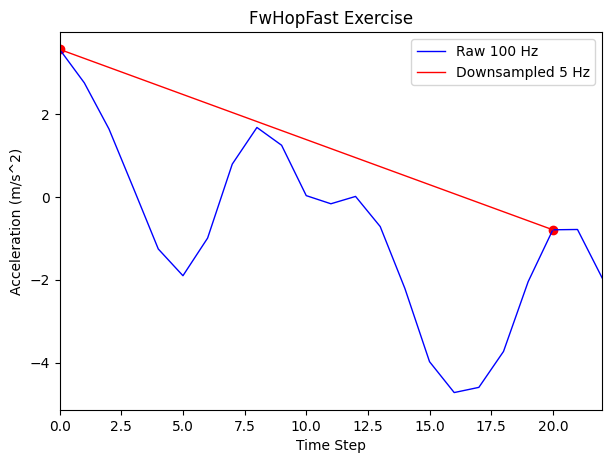

In [ ]:
fig, ax = plt.subplots(figsize=(7,5), dpi=100)
selected_exercise = exercise_types[9]

for i in range(len(sample_list)):
  if sample_list[i][0, ID_EXERCISE_LABEL] == label_code[selected_exercise]:
    raw_signal_t = sample_list[i][:, 15]
    ds_signal_t, d_t = downsample_a_signal(raw_signal_t, DOWNSAMPLE_FACTOR)
    break

ax.plot(raw_signal_t, linewidth = 1, color = 'b', label = 'Raw 100 Hz')
ax.plot(d_t, ds_signal_t, linewidth = 1, linestyle = '-', color = 'r', label = 'Downsampled ' + str(int(100/DOWNSAMPLE_FACTOR)) + ' Hz')
ax.scatter(d_t, ds_signal_t, color = 'r')

print(len(raw_signal_t))
print(len(ds_signal_t))
    
ax.set_xlim([0, len(raw_signal_t)-1])
ax.set_xlabel('Time Step')
ax.set_ylabel('Acceleration (m/s^2)')
ax.set_title(selected_exercise + ' Exercise')
plt.legend()

Text(0.5, 1.0, 'FwHopFast Exercise')

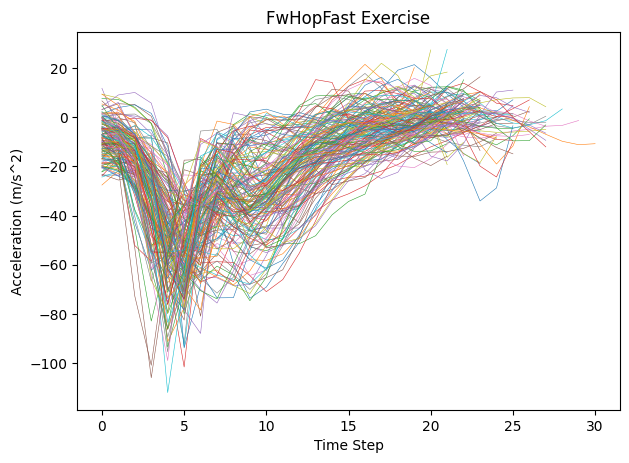

In [ ]:
fig, ax = plt.subplots(figsize=(7,5), dpi=100)

for i in range(len(sample_list)):
  if sample_list[i][0, ID_EXERCISE_LABEL] == label_code[selected_exercise]:
    # ax.plot(sample_list[i][:, 18], linewidth = 0.4, color = '0.8')
    ax.plot(sample_list[i][:, 18], linewidth = 0.4)
    
# ax.set_xlim([0, len(raw_signal_t)-1])
ax.set_xlabel('Time Step')
ax.set_ylabel('Acceleration (m/s^2)')
ax.set_title(selected_exercise + ' Exercise')

Visualization

In [ ]:
# --- Normalize samples (to 100) --- #
norm_sample_list = []

for t_sample in tqdm(ds_sample_list):
  t_norm_sample = normLength(t_sample, NORM_SAMPLE_LENGTH)
  norm_sample_list.append(t_norm_sample)

100%|██████████| 3212/3212 [00:11<00:00, 268.17it/s]


In [ ]:
# Get the label (i.e., exercise type of a sample)
print(len(norm_sample_list))
print(norm_sample_list[300][0, -1])
print(norm_sample_list[300].shape)

3212
2.0
(100, 63)


In [ ]:
# --- Frame data --- #
dt_frame = []
ex_label = []
num_samples = len(norm_sample_list)

for i in range(num_samples):
  dt_frame.append(norm_sample_list[i][:, 0:60].flatten('F'))
  ex_label.append(norm_sample_list[i][0, ID_EXERCISE_LABEL])

dt_frame = np.array(dt_frame)
ex_label = np.array(ex_label)

In [ ]:
dt_frame.shape

(3212, 6000)

In [ ]:
np.unique(ex_label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.])

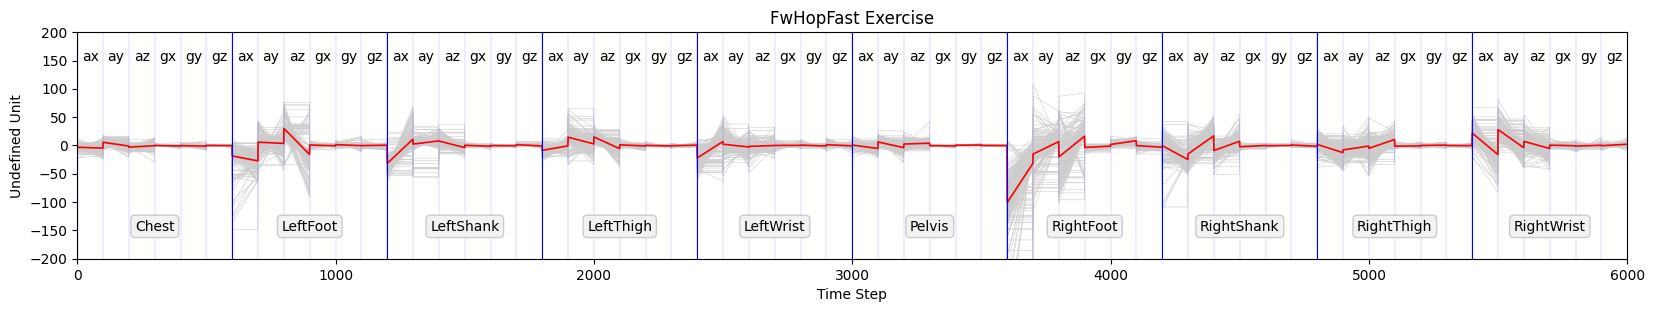

170


In [ ]:
# --- Plot --- #
# visualize a specific task
fig, ax = plt.subplots(figsize=(20,3), dpi=100)
# fig, ax = plt.subplots(figsize=(7,5), dpi=100)
selected_exercise = exercise_types[9]
temp_no_samples = 0

ex_all_reps_line = []
for i in range(num_samples):
  if ex_label[i] == label_code[selected_exercise]:
    ax.plot(dt_frame[i, :], linewidth = 0.4, color = '0.8')
    ex_all_reps_line.append(dt_frame[i, :])
    temp_no_samples += 1

ax.set_xlim([0, 6000])
ax.set_xlabel('Time Step')
ax.set_ylabel('Undefined Unit')
ax.set_title(selected_exercise + ' Exercise')

ex_all_reps_line = np.array(ex_all_reps_line)
ex_avg_line = np.mean(ex_all_reps_line, axis = 0)
ax.plot(ex_avg_line, 'r', linewidth = 1.2)
bound = np.max(np.abs(ex_avg_line))
# ax.set_ylim([-2*bound, 2*bound])
ax.set_ylim([-200, 200])

# Segment different sensor positions
for i in range(len(CONSIDERED_IMU_POSITION)):
  ax.axvline(i*600, linewidth = 0.8, color = 'b')
  # ax.annotate(CONSIDERED_IMU_POSITION[i], (i*600 + 300, -1.5*bound), ha = 'center', bbox = dict(boxstyle ="round", fc ="0.95", ec = '0.8'))
  ax.annotate(CONSIDERED_IMU_POSITION[i], (i*600 + 300, -150), ha = 'center', bbox = dict(boxstyle ="round", fc ="0.95", ec = '0.8'))
# Segment different sensor type (i.e., accelerometer and gyroscope)
ga_label = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
for i in range(conv_num_in):
  ax.axvline(i*100, linewidth = 0.1, color = 'b')
  # ax.annotate(ga_label[int(i % len(ga_label))], (i*100 + 50, 1.5*bound), ha = 'center')
  ax.annotate(ga_label[int(i % len(ga_label))], (i*100 + 50, 150), ha = 'center')

# # The average line only
# fig1, ax1 = plt.subplots(figsize=(7,5), dpi=100)
# ax1.plot(ex_avg_line, 'r-', linewidth = 1.2)

# ax1.set_xlim([0, 6000])
# ax1.set_xlabel('Time Step')
# ax1.set_ylabel('Undefined Unit')
# ax1.set_title(selected_exercise + ' Exercise')
# # ax1.set_ylim([-65, 65])

plt.show()
print(temp_no_samples)

#The loop

Check device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Performance evaluation *(with tuned hyper-parameters recorded from the tuning)*

In [ ]:
# Removed subject 1 due to missing IMUs
all_subject_id = list(range(1, NUM_SUBJECT))
# all_subject_id = list(range(1, 19))

# Training/testing accuracy of performance evaluation
perf_train_acc = []
perf_test_acc = []

# Training/testing confusion matrices
perf_train_cm = []
perf_test_cm = []

# Testing prediction performance
perf_test_y_pred = []
perf_test_y_truth = []

# Performance evaluation
# for test_subject in all_subject_id[0:1]: # for testing purpose
for test_subject in all_subject_id[:]:
  print('# Working on test subject ' + str(test_subject))

  # --- Divide training/testing data according to LOSOCV --- #
  train_list, test_list = [], []

  # # UNCOMMENT THIS ONCE FINISHING TESTING 
  # for sample in ds_sample_list:    
  #   if sample[0, ID_SUBJECT_LABEL] != test_subject: # data not from the testing subject
  #     train_list.append(sample) 
  #   else: # data from the testing subject
  #     test_list.append(sample)  

  for sample in ds_sample_list:    
    if sample[0, ID_SUBJECT_LABEL] in [train_subject for train_subject in all_subject_id if train_subject != test_subject]:
      train_list.append(sample) 
    elif sample[0, ID_SUBJECT_LABEL] == test_subject:
      test_list.append(sample)  
    else: 
      pass
  
  print('* training size: ' + str(len(train_list)))
  print('* testing size: ' + str(len(test_list)))

  # --- Obtain hyper-parameters from the pre-tuning process --- #
  print('--- Obtain hyper-parameters')
  hp_point = TUNED_HP[test_subject] # get the set of tune hyper-parameters
  s_batch_size  = hp_point[ID_BATCH_SIZE]
  s_num_out     = hp_point[ID_NUM_OUT]
  s_kernel_size = hp_point[ID_KERNEL_SIZE]
  s_stride      = hp_point[ID_STRIDE] 
  s_pool_size   = hp_point[ID_POOL_SIZE]

  print(' + batch size = ' + str(s_batch_size))
  print(' + conv. num. out = ' + str(s_num_out))
  print(' + kernel size = ' + str(s_kernel_size))
  print(' + stride length = ' + str(s_stride))
  print(' + pool size = ' + str(s_pool_size))

  # --- Make dataset --- #
  # Normalize
  train_data  = MyDataset(train_list, NORM_SAMPLE_LENGTH, num_clusters) # <-- Here to modify the number of classes (i.e., num_clusters or num_exercise)
  test_data   = MyDataset(test_list, NORM_SAMPLE_LENGTH, num_clusters) # <-- Here to modify the number of classes (i.e., num_clusters or num_exercise)

  # Wrap dataloader   
  train_dataloader  = DataLoader(train_data, batch_size = s_batch_size, shuffle=True)
  test_dataloader   = DataLoader(test_data, batch_size  = s_batch_size, shuffle=False)

  # --- Model and training --- #
  # Model
  # model = CNN_One_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Two_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Three_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_One_Deep_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Two_Deep_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  # model = CNN_Parallel_Blocks(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size)
  model = CNN_Alter_Block(conv_num_in, s_num_out, s_kernel_size, s_stride, s_pool_size, num_clusters) # <-- Here to modify the number of classes (i.e., num_clusters or num_exercise)
  if device == 'cuda': model = model.cuda()

  # for plotting
  train_losses, val_losses = [], []

  # Initialize the loss function
  loss_fn = nn.CrossEntropyLoss()

  # Initialize the optimisation function
  optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = ADAM_WEIGHT_DECAY)

  # Scheduler
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = LEARNING_RATE_REDUCTION_FACTOR)

  print('--- Start the performance evaluation')
  for t in range(NUM_EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    temp_train_acc, temp_train_cm, _, _  = train_loop(train_dataloader, model, loss_fn, optimizer, num_clusters) # <-- Here to modify the number of classes (i.e., num_clusters or num_exercise)
    temp_test_acc, temp_test_cm, temp_y_truth, temp_y_pred   = test_loop(test_dataloader, model, loss_fn, num_clusters) # <-- Here to modify the number of classes (i.e., num_clusters or num_exercise)

  # Store the training/testing performance
  print('*** Training/testing performance')
  perf_train_acc.append(temp_train_acc)
  perf_test_acc.append(temp_test_acc)
  print(perf_train_acc)
  print(perf_test_acc)

  # Store the confusion matrices
  print('*** Confusion matrix')  
  perf_train_cm.append(temp_train_cm)
  perf_test_cm.append(temp_test_cm)
  print('Not displayed but added')
  # print(perf_train_cm)
  # print(perf_test_cm)

  perf_test_y_truth.append(temp_y_truth)
  perf_test_y_pred.append(temp_y_pred)


# Working on test subject 1
* training size: 3064
* testing size: 148
--- Obtain hyper-parameters
 + batch size = 128
 + conv. num. out = 256
 + kernel size = 4
 + stride length = 1
 + pool size = 2


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


--- Start the performance evaluation
Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
--------------------

Monitor the performance

In [ ]:
# Compute the average training/testing accuracy
avg_train_acc = round((sum(perf_train_acc)*100.0/len(perf_train_acc)), 4)
avg_test_acc = round((sum(perf_test_acc)*100.0/len(perf_test_acc)), 4)

print('Average training accuracy = ' + str(avg_train_acc))
print('Average testing accuracy = ' + str(avg_test_acc))

Average training accuracy = 99.6542
Average testing accuracy = 90.4551


In [ ]:
# Plot confusion matrices
import seaborn as sns 

verf_count = 0

for i in range(len(perf_test_cm)):
  # plt.figure(i)
  # sns.heatmap(perf_test_cm[i], cmap = 'YlGnBu')
  # plt.title('No. samples = ' + str(np.sum(perf_test_cm[i])) + '\n' + '(Testing) accuracy = ' + str(perf_test_acc[i]))
  # plt.xlabel('Prediction')
  # plt.ylabel('Truth')

  verf_count = verf_count + np.sum(perf_test_cm[i])

print('Would be wrong if verf_count is not the total number of samples in the dataset, i.e., 3212')
print(verf_count)

Would be wrong if verf_count is not the total number of samples in the dataset, i.e., 3212
3212.0


Store result for later processing

In [ ]:
# Store accuracy
with open('train_acc.npy', 'wb') as f:
  np.save(f, np.array(perf_train_acc))
with open('test_acc.npy', 'wb') as f:
  np.save(f, np.array(perf_test_acc))

# Store confusion matrices
with open('train_cm.npy', 'wb') as f:
  np.save(f, np.array(perf_train_cm))
with open('test_cm.npy', 'wb') as f:
  np.save(f, np.array(perf_test_cm))

# Store truth and pred values of the testing set
with open('test_y_truth.npy', 'wb') as f:
  np.save(f, np.array(perf_test_y_truth))
with open('test_y_pred.npy', 'wb') as f:
  np.save(f, np.array(perf_test_y_pred))

<ipython-input-553-ef51fbbcb0b2>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f, np.array(perf_test_y_truth))
<ipython-input-553-ef51fbbcb0b2>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f, np.array(perf_test_y_pred))


#Post-process the results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

Read data

In [ ]:
# Retrieve accuracy
with open('train_acc.npy', 'rb') as f:
  r_train_acc = np.load(f)
with open('test_acc.npy', 'rb') as f:
  r_test_acc = np.load(f)

# Retrieve confusion matrices
with open('train_cm.npy', 'rb') as f:
  r_train_cm = np.load(f)
with open('test_cm.npy', 'rb') as f:
  r_test_cm = np.load(f)

# Retrieve y truth and pred
with open('test_y_truth.npy', 'rb') as f:
  r_y_truth = np.load(f, allow_pickle = True)
with open('test_y_pred.npy', 'rb') as f:
  r_y_pred = np.load(f, allow_pickle = True)

In [ ]:
# Normalize confusion matrix
def normalize_cm(cm):
  norm_cm = np.zeros(cm.shape) # init

  num_sbj = cm.shape[0]
  num_ex = cm.shape[1]

  # Loop through subject with different confusion matrices
  for s in range(num_sbj):

    # Loop through exercises
    for e in range(num_ex):

      # Check if there is missing exercise
      num_trial = sum(cm[s][e, :])

      if num_trial != 0:
        norm_cm[s][e, :] = cm[s][e, :]/num_trial
      else:
        pass # do nothing since the row is already zero

  return norm_cm

# Average the normalize confusion matrix
def get_avg_cm(norm_cm):
  num_sbj = norm_cm.shape[0]
  num_ex = norm_cm.shape[1]

  avg_norm_cm = np.zeros([num_ex, num_ex]) # init
  num_trials = np.zeros(num_ex) # store the no. of trials for each exercise

  # Loop through subjects
  for s in range(num_sbj):
     
     # Loop through exercises
     for e in range(num_ex):

      # Check if there is missing trial
      if sum(norm_cm[s][e, :]) != 0:
        avg_norm_cm[e, :] = avg_norm_cm[e, :] + norm_cm[s][e, :]
        num_trials[e] = num_trials[e] + 1
      else:
        pass

  # Compute the average
  for e in range(num_ex):
    avg_norm_cm[e, :] = avg_norm_cm[e, :]/num_trials[e]

  return avg_norm_cm

# Get precision, recall, and F1-score (averaged across exercises and subjects) from confusion matrices
def get_avg_metrics_from_cm(cm):
  precision_mat = np.zeros([19, 37]) # each row is a subject, each column is an exercise
  recall_mat = np.zeros([19, 37])
  f1_score_mat = np.zeros([19, 37])

  num_sbj = cm.shape[0]
  num_ex = cm.shape[1]

  for s in range(num_sbj):

    for e in range(num_ex):
      
      # Compute precision
      if sum(cm[s][:, e]) != 0:
        temp_precision = cm[s][e, e] / sum(cm[s][:, e])        
      else:
        temp_precision = 0
      precision_mat[s, e] = temp_precision

      # Compute recall
      if sum(cm[s][e, :]) != 0:
        temp_recall = cm[s][e, e] / sum(cm[s][e, :])
      else:
        temp_recall = 0
      recall_mat[s, e] = temp_recall

      # Compute F1-score
      if (temp_precision != 0) and (temp_recall != 0):
        temp_f1 = 2*(temp_recall*temp_precision)/(temp_recall + temp_precision)
      else:
        temp_f1 = 0
      f1_score_mat[s, e] = temp_f1
  
  # Average
  precision = precision_mat.mean()
  recall = recall_mat.mean()
  f1 = f1_score_mat.mean()

  return precision, recall, f1

In [ ]:
norm_train_cm = normalize_cm(r_train_cm)
norm_test_cm = normalize_cm(r_test_cm)

In [ ]:
sbj_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22]

for i in range(len(r_test_cm)):
  plt.figure(i)
  sns.heatmap(r_test_cm[i], cmap = 'YlGnBu')
  plt.title('S' + str(sbj_list[i]) + ' left for testing')
  plt.xlabel('Prediction')
  plt.ylabel('Truth')

In [ ]:
sbj_list = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22]

for i in range(len(norm_test_cm)):
  plt.figure(i)
  sns.heatmap(norm_test_cm[i], cmap = 'YlGnBu')
  plt.title('S' + str(sbj_list[i]) + ' left for testing')
  plt.xlabel('Prediction')
  plt.ylabel('Truth')

In [ ]:
avg_norm_cm = get_avg_cm(norm_test_cm)

Text(69.0, 0.5, 'Truth')

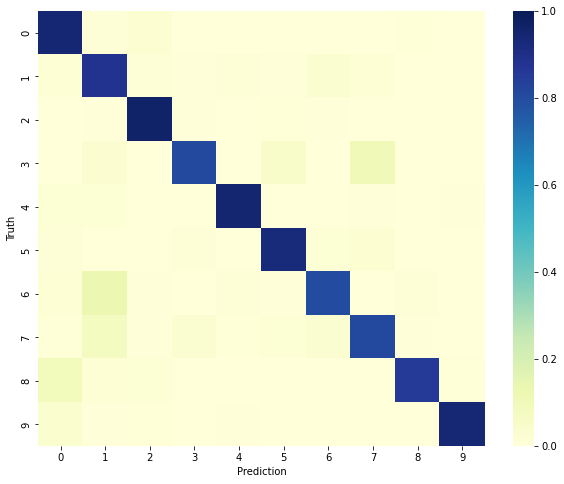

In [ ]:
plt.figure(figsize = (10, 8))
sns.heatmap(avg_norm_cm, cmap = 'YlGnBu', vmin = 0, vmax = 1)
plt.xlabel('Prediction')
plt.ylabel('Truth')

In [ ]:
pd.DataFrame(r_train_acc)

,0
0,0.996084
1,0.996063
2,0.997047
3,0.996399
4,0.995734
5,0.995404
6,0.996714
7,0.997382
8,0.995749
9,0.996717


In [ ]:
pd.DataFrame(r_test_acc)

,0
0,0.945946
1,0.926829
2,0.939024
3,0.929936
4,0.763636
5,0.957831
6,0.964497
7,0.871795
8,0.909091
9,0.819277


Get precision, recall, and F1-score

In [ ]:
# Precision
precision_arr = []
for i in range(19):
  precision_arr.append(precision_score(r_y_truth[i], r_y_pred[i], average = 'macro'))

pd.DataFrame(precision_arr)

,0
0,0.924099
1,0.933333
2,0.911550
3,0.923418
4,0.642529
5,0.929239
6,0.950216
7,0.888337
8,0.882573
9,0.771975


In [ ]:
# Recall
recall_arr = []
for i in range(19):
  recall_arr.append(recall_score(r_y_truth[i], r_y_pred[i], average = 'macro'))

pd.DataFrame(recall_arr)

,0
0,0.954183
1,0.881786
2,0.950321
3,0.902406
4,0.728869
5,0.977468
6,0.955909
7,0.913483
8,0.847429
9,0.737814


In [ ]:
# F1-score
f1_arr = []

for i in range(19):
  f1_arr.append(f1_score(r_y_truth[i], r_y_pred[i], average = 'macro'))

pd.DataFrame(f1_arr)

,0
0,0.934845
1,0.887466
2,0.923484
3,0.911410
4,0.668196
5,0.948676
6,0.951943
7,0.896981
8,0.842663
9,0.728359
